# Read Data

In [3]:
import pandas as pd

feature_names=["Age", "Workclass", "Final Weight", "Education", "Education-Num", "Marital Status",
               "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
               "Hours per week", "Country", "Income"]

df_train=pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                     names=feature_names)

df_test=pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                    skiprows =1,
                    names=feature_names)



# Data prep & problem definition

In [4]:
SAMPLE_ROWS=5000

def df_prep(df):
    df=df.copy().sample(SAMPLE_ROWS)
    LABEL="Income"
    y_train=df[LABEL].replace([" <=50K"," <=50K."," >50K"," >50K."],[0,0,1,1])
    df_X=df.drop(LABEL, axis=1)
    return df_X,y_train

df_X_train,y_train=df_prep(df_train)
df_X_test,y_test=df_prep(df_test)

# Very basic feature/classifier pipeline

In [5]:
import numpy as np
from sklearn_pandas import gen_features
from sklearn_pandas import DataFrameMapper
import sklearn.preprocessing as preprocessing

nums=[ ([c],preprocessing.Imputer()) for c in df_X_train.select_dtypes([np.number])]
cats=[ ([c],preprocessing.LabelBinarizer()) for c in df_X_train.select_dtypes(["object"])]

feature_mapper=DataFrameMapper(nums+cats,df_out=True)
feature_mapper

DataFrameMapper(default=False, df_out=True,
        features=[(['Age'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), (['Final Weight'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), (['Education-Num'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), (['C...sparse_output=False)), (['Country'], LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False))],
        input_df=False, sparse=False)

In [79]:
from sklearn.pipeline import Pipeline
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier

param_dist = {
              # Note n_estimators probably not a true hyperparameter, 
              # in general more is better (aside performance/diminishing returns)
              "classifier__n_estimators": [10,20],
              "classifier__max_features": ['auto', 'sqrt', 'log2'],
              "classifier__max_depth": [1,8],
              "classifier__min_samples_leaf": [1,8],
              "classifier__bootstrap": [True,False],
              "classifier__n_jobs":[-1],
              "classifier__criterion" :['gini', 'entropy']
             }

classifier = RandomForestClassifier(random_state=42)

pipeline=Pipeline([('featurize', feature_mapper),
                   ('classifier',classifier)])

In [80]:
from sklearn.model_selection import GridSearchCV

# Quick grid search
CV=3

search_cv = GridSearchCV(pipeline, param_grid=param_dist,
                                   n_jobs=1,
                                   scoring="roc_auc",
                                   error_score=0,cv=CV,verbose=5,
                                   
                                   #will not be default for sklearn .021
                                   return_train_score=True)

search_cv.fit(df_X_train,y_train)

clf=search_cv.best_estimator_
clf

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=1, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__n_estimators=10, classifier__n_jobs=-1 
[CV]  classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=1, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__n_estimators=10, classifier__n_jobs=-1, score=0.8388277393581713, total=   0.4s
[CV] classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=1, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__n_estimators=10, classifier__n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=1, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__n_estimators=10, classifier__n_jobs=-1, score=0.8245903584891239, total=   0.4s
[CV] classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=1, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__n_estimators=10, classifier__n_jobs=-1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=1, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__n_estimators=10, classifier__n_jobs=-1, score=0.8668694502096616, total=   0.4s
[CV] classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=1, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__n_estimators=20, classifier__n_jobs=-1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s


[CV]  classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=1, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__n_estimators=20, classifier__n_jobs=-1, score=0.8589427165679022, total=   0.4s
[CV] classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=1, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__n_estimators=20, classifier__n_jobs=-1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.9s remaining:    0.0s


[CV]  classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=1, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__n_estimators=20, classifier__n_jobs=-1, score=0.8409679729332866, total=   0.4s
[CV] classifier__bootstrap=True, classifier__criterion=gini, classifier__max_depth=1, classifier__max_features=auto, classifier__min_samples_leaf=1, classifier__n_estimators=20, classifier__n_jobs=-1 


KeyboardInterrupt: 

# Prepare dataframe for Dash

In [63]:
cv_results_df=pd.DataFrame(search_cv.cv_results_).sort_values(by='rank_test_score')
cv_results_df["dif_test_train"]=cv_results_df.mean_train_score-cv_results_df.mean_test_score

# drop param list column, doesnt work in dash, not needed for now
cv_results_df.drop("params",axis=1,inplace=True)

cv_results_df


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__bootstrap,param_classifier__criterion,param_classifier__max_depth,param_classifier__max_features,param_classifier__min_samples_leaf,param_classifier__n_estimators,...,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score,dif_test_train
98,0.293997,0.019440,0.148001,0.003559,True,entropy,8,sqrt,1,40,...,0.902015,0.907172,0.006147,1,0.937665,0.939355,0.938127,0.938382,0.000713,0.031211
92,0.300667,0.012257,0.148336,0.001248,True,entropy,8,auto,1,40,...,0.902015,0.907172,0.006147,1,0.937665,0.939355,0.938127,0.938382,0.000713,0.031211
146,0.296999,0.009200,0.159004,0.002948,False,gini,8,auto,1,40,...,0.903147,0.906732,0.005731,3,0.941294,0.943237,0.944918,0.943150,0.001481,0.036417
152,0.350668,0.026714,0.170667,0.012283,False,gini,8,sqrt,1,40,...,0.903147,0.906732,0.005731,3,0.941294,0.943237,0.944918,0.943150,0.001481,0.036417
44,0.301331,0.023213,0.162336,0.005251,True,gini,8,sqrt,1,40,...,0.901080,0.905514,0.006539,5,0.938398,0.942302,0.940659,0.940453,0.001601,0.034939
38,0.321664,0.015924,0.155339,0.003305,True,gini,8,auto,1,40,...,0.901080,0.905514,0.006539,5,0.938398,0.942302,0.940659,0.940453,0.001601,0.034939
155,0.308335,0.003854,0.151999,0.002940,False,gini,8,sqrt,8,40,...,0.901801,0.904926,0.006580,7,0.922311,0.924506,0.926751,0.924523,0.001813,0.019597
149,0.309999,0.070412,0.148108,0.000944,False,gini,8,auto,8,40,...,0.901801,0.904926,0.006580,7,0.922311,0.924506,0.926751,0.924523,0.001813,0.019597
206,0.544331,0.062961,0.197004,0.025664,False,entropy,8,sqrt,1,40,...,0.900718,0.904625,0.005922,9,0.937739,0.940967,0.940305,0.939670,0.001392,0.035045
200,0.364985,0.088467,0.150817,0.010380,False,entropy,8,auto,1,40,...,0.900718,0.904625,0.005922,9,0.937739,0.940967,0.940305,0.939670,0.001392,0.035045


# Dash 

In [64]:
import os
# From awesome dash intro repo by Kevin Mader
# A quick intro to Dash made for the PyData event in Zurich
# https://github.com/4QuantOSS/DashIntro 

# Can use Jupyter nbserverproxy extension (available at /.../proxy/<port>)

def show_app(app, port = 10001, 
             width = 700, 
             height = 350, 
             offline = False,
            in_binder = None):
    in_binder ='JUPYTERHUB_SERVICE_PREFIX' in os.environ if in_binder is None else in_binder
    if in_binder:
        base_prefix = '{}proxy/{}/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)
        url = 'https://hub.mybinder.org{}'.format(base_prefix)
        app.config.requests_pathname_prefix = base_prefix
    else:
        url = 'http://localhost:%d' % port
    iframe = '<a href="{url}" target="_new">Open in new window</a><hr><iframe src="{url}" width={width} height={height}></iframe>'.format(url = url, 
                                                                                  width = width, 
                                                                                  height = height)

    iframe = '<a href="{url}" target="_new">Open in new window</a><hr>'.format(url = url, 
                                                                                  width = width, 
                                                                                  height = height)

    display.display_html(iframe, raw = True)
    if offline:
        app.css.config.serve_locally = True
        app.scripts.config.serve_locally = True
        
    return app.run_server(debug=False, # needs to be false in Jupyter
                          host = '0.0.0.0',
                          port=port)

C:\tools\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

C:\tools\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

C:\Users\rquintino\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\tools\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



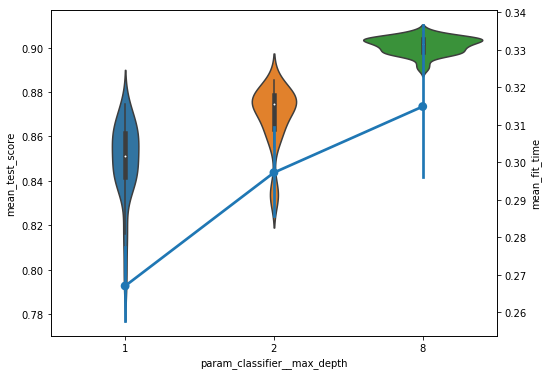

In [65]:
import sklearn.metrics as metrics
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt

def serve_param_figure(df,col,metric_1,metric_2):
  
    split_col=""
    fig=plt.figure(figsize=(8,6))
    sns.violinplot(x=col, y=metric_1,data=df)
    ax2 = plt.twinx()
    sns.pointplot(x=col, y=metric_2,ax=ax2, data=df)
    
    return fig

# Test
df=cv_results_df
metric_1="mean_test_score"
metric_2="mean_fit_time"
col="param_classifier__max_depth"

fig=serve_param_figure(cv_results_df,col,metric_1,metric_2)

fig

In [74]:
import sklearn.linear_model as linear_model
import statsmodels.api as sm
import numpy as np
from scipy import stats
from IPython.display import display as display

# Needs review... use builtin instead
def serve_regression_stats(df,score_result):

    def drop_constant_columns(dataframe):
        return dataframe.loc[:, (dataframe != dataframe.iloc[0]).any()]

    all_reg=drop_constant_column(df)

    reg_cols=[]
    cat_cols=[]
    for col in all_reg.columns:
        if  col.startswith("param_") or col==score_result:
            reg_cols.append(col)

    all_reg=all_reg[reg_cols]
    all_reg=all_reg.convert_objects(convert_numeric=True)
    all_reg

    cat_cols=all_reg.select_dtypes(include=['object','category','bool']).columns
    cat_cols
    all_reg=pd.get_dummies(all_reg, columns=cat_cols,drop_first=True).fillna(0)
    all_reg

    y=all_reg[score_result].values
    X=all_reg.drop(score_result,axis=1)
    X_df=X

    X = pd.DataFrame(X, columns = X_df.columns)
    
    lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
    lm.fit(X,y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    # https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression/46912457
    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    results_df = pd.DataFrame()
    results_df["Column"]=X_df.columns.insert(0,"intercept/default")
    results_df["Coefficients"],results_df["Standard Errors"],results_df["t values"],results_df["Probabilites"] = [params,sd_b,ts_b,p_values]

    results_df["AbsCoef"]=abs(results_df["Coefficients"])

    results_df["p?"]=np.where(results_df['Probabilites']<.005, '***', np.where(results_df['Probabilites']<.05, '*', ''))

    results_df.sort_values(["p?","AbsCoef"],ascending=False,inplace=True)
    
    results_df.drop("t values",axis=1,inplace=True)
    return results_df

# Test
serve_regression_stats(cv_results_df,"mean_test_score")


C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning:

convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.



,Column,Coefficients,Standard Errors,Probabilites,AbsCoef,p?
0,intercept/default,0.8346,0.003,0.000,0.8346,***
6,param_classifier__max_features_log2,-0.0100,0.002,0.000,0.0100,***
1,param_classifier__max_depth,0.0068,0.000,0.000,0.0068,***
3,param_classifier__n_estimators,0.0007,0.000,0.000,0.0007,***
5,param_classifier__criterion_gini,0.0019,0.001,0.203,0.0019,
4,param_classifier__bootstrap_True,0.0010,0.001,0.507,0.0010,
2,param_classifier__min_samples_leaf,-0.0001,0.000,0.522,0.0001,
7,param_classifier__max_features_sqrt,0.0000,0.002,1.000,0.0000,


In [75]:
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import dash
from dash.dependencies import Input, Output, State,Event
import dash_core_components as dcc
import dash_html_components as html
import dash_table_experiments as dt
import json
import plotly
from IPython import display
from matplotlib import rcParams

app = dash.Dash()

metrics_list=cv_results_df.columns.values

def fig_to_uri(in_fig, close_all=True, **save_args):
    rcParams.update({'figure.autolayout': False})
    out_img = BytesIO()
    # cut issue: https://stackoverflow.com/questions/29901422/matplotlib-with-annotation-cut-off-from-the-saved-figure/29901470
    in_fig.savefig(out_img, format='png',bbox_inches="tight", **save_args)
    if close_all:
        in_fig.clf()
        plt.close('all')
    out_img.seek(0)  # rewind file
    encoded = base64.b64encode(out_img.read()).decode("ascii").replace("\n", "")
    return "data:image/png;base64,{}".format(encoded)

app.layout = html.Div([
    # Reference: https://github.com/plotly/dash-svm/
    # .container class is fixed, .container.scalable is scalable
    html.Div(className="banner", children=[
        html.Div(className='container scalable', children=[
            html.H2(html.A(
                'Dash Search CV Eval - DevScope AI Lab',
                href='https://github.com/DevScope/ai-lab',
                style={
                    'text-decoration': 'none',
                    'color': 'inherit'
                }
            )),

            html.A(
                html.Img(src="https://s3-us-west-1.amazonaws.com/plotly-tutorials/logo/new-branding/dash-logo-by-plotly-stripe-inverted.png"),
                href='https://plot.ly/products/dash/'
            )
        ]),
    ]),
    html.Div(id='body', className='container scalable', children=[
         html.Div([
            html.Div(
                [
                    dt.DataTable(
                        rows=cv_results_df.to_dict('records'),
                        editable=False,
                        sortable=True,
                        columns=cv_results_df.columns.values,
                        row_selectable=False,
                        filterable=True,
                        max_rows_in_viewport=4,
                        id='score_table'
                        ),
                    
                    dt.DataTable(
                        rows=[{'No Rows': ''}],
                        editable=False,
                        sortable=True,
                        #columns=cv_results_df.columns.values,
                        row_selectable=False,
                        filterable=True,
                        max_rows_in_viewport=4,
                        id='regression_table'
                        ),
                ],className="six columns"),
             html.Div(
                 [
                     html.Div(className="row",children=[
                         dcc.Dropdown(
                             id='metric_1',
                             options=[{'label':label,'value':label} for label in metrics_list],
                             value="mean_test_score",
                             placeholder="Main axis",
                             className="six columns"
                            ),
                        dcc.Dropdown(
                             id='metric_2',
                             options=[{'label':label,'value':label} for label in metrics_list],
                             value="mean_fit_time",
                             placeholder="Secondary axis",
                            className="six columns"
                            )]),
                    html.Div(id="output",style={'height':'500px','overflow-y': 'scroll'})
                   ],id="results",className="six columns")
        ],className="row")
     ])
])

@app.callback(
   Output('regression_table', 'rows'),
   [Input("score_table","rows"),Input("metric_1","value"),Input("metric_2","value")])
def update_regression_table(rows,metric_1,metric_2):
    if len(rows)==0:
        return []
    
    children=[]
    
    df_selected = pd.DataFrame(rows)
    
    df_regression= serve_regression_stats(df_selected,metric_1)
    
    return df_regression.to_dict('records')
    
@app.callback(
   Output('output', 'children'),
   [Input("score_table","rows"),Input("metric_1","value"),Input("metric_2","value")])
def update_output_table(rows,metric_1,metric_2):
    if len(rows)==0:
        return []
    
    children=[]
    
    #rebuild dataframe from received data
    df_selected = pd.DataFrame(rows)
    
    for col in df_selected.columns:
        if col.startswith("param_") and len(df_selected[col].unique())>1:
            col_figure = serve_param_figure(df_selected,col,metric_1,metric_2)
            children.append(html.Img(src = fig_to_uri(col_figure)))
    
    return children

# Reference: https://github.com/plotly/dash-svm/
external_css = [
    # Normalize the CSS
    "https://cdnjs.cloudflare.com/ajax/libs/normalize/7.0.0/normalize.min.css",
    # Fonts
    "https://fonts.googleapis.com/css?family=Open+Sans|Roboto",
    "https://maxcdn.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css",
    # Base Stylesheet, replace this with your own base-styles.css using Rawgit
    "https://rawgit.com/xhlulu/9a6e89f418ee40d02b637a429a876aa9/raw/f3ea10d53e33ece67eb681025cedc83870c9938d/base-styles.css",
    # Custom Stylesheet, replace this with your own custom-styles.css using Rawgit
    "https://cdn.rawgit.com/plotly/dash-svm/bb031580/custom-styles.css"
]

for css in external_css:
    app.css.append_css({"external_url": css})
    

In [76]:
# use <esc> i+i on Jupyter to quick interrupt & get control back to jupyter
show_app(app=app,port=10003)


Open in new window

 * Running on http://0.0.0.0:10003/ (Press CTRL+C to quit)
127.0.0.1 - - [21/Aug/2018 00:56:27] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2018 00:56:31] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2018 00:56:31] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2018 00:56:31] "GET /favicon.ico HTTP/1.1" 200 -
C:\tools\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

C:\tools\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

C:\Users\rquintino\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\t